In [53]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Forward Problem - Generating Training Data</h3>

In [54]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:]
    # that can be strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [55]:
# set radius of spatial domain
bigL = 16

# set real space grid, used for plotting
nx = 1025
# dx is needed to perform norm check of training data
xvec, dx = np.linspace(-bigL, bigL, nx, retstep=True)

# set number of Fourier basis
nfb = 128
# matrix for converting Fourier basis coefficients to real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
fbmat = (1 / np.sqrt(2 * bigL)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / bigL)

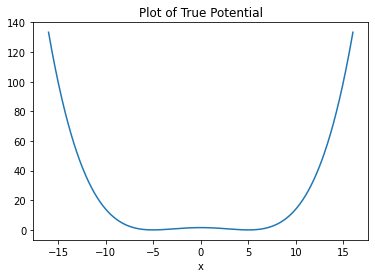

In [56]:
# define potential for generating training data

def v(x, choice=1):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Potential Function: Choice not recognised.')
        return None

# compute true potential
vxtru = v(xvec)

# plot true potential
plt.plot(xvec, vxtru)
plt.title('Plot of True Potential')
plt.xlabel('x')
plt.show()

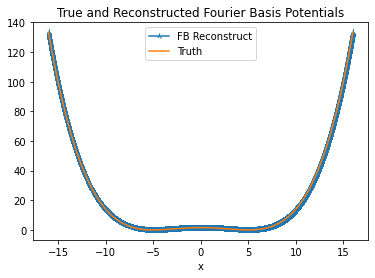

In [57]:
# this code transforms the true potential to the
# Fourier basis

# fbres can be adjusted to improve the Fourier basis resolution
# if we set fbres = 1, then fsample = 2*nfb, which is the
# Nyquist frequency
fbres = 100
fbsample = fbres * 2 * nfb
xfbvec = np.linspace(-bigL, bigL, fbsample+2)
vfbvec = np.fft.rfft(v(xfbvec), norm='forward')
vfbvecrec = np.fft.irfft(vfbvec, norm='forward')

# plot potentials
plt.plot(xfbvec, vfbvecrec, '2-', label='FB Reconstruct')
plt.plot(xvec, vxtru, label='Truth')
plt.title('True and Reconstructed Fourier Basis Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

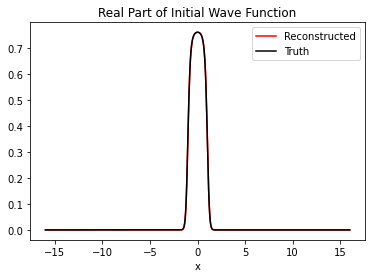

Relative norm difference: 5.020489938217769e-05


In [58]:
# this code transforms the initial state psi0 to the Fourier basis
# the resulting vector is called inita

def getinita():
    def psi0(x, choice=0):
        if choice == 0:
            # rounded box function
            return 1.0 + np.tanh((1 - x**2)/0.5)
        elif choice == 1:
            # triangular pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
        elif choice == 2:
            # parabolic pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
        elif choice == 3:
            # hyperbolic secant squared
            return (np.cosh(x))**(-2)
        elif choice == 4:
            # Laplace
            return np.exp(-np.abs(x))
        else:
            print('Initial State Function: Did not recognise your choice.')
            return None

    # compute psi0 normalization term,
    # this is a constant given some psi0
    psi0prob = lambda z: np.abs(psi0(z))**2
    norm = np.sqrt(si.quad(psi0prob, a=-bigL, b=bigL)[0])

    # function for computing normalized psi0,
    # used in integration method
    def normpsi0(x):
        return psi0(x)/norm

    # transform psi0 to Fourier basis using quadrature method
    # i.e., compute the Fourier coefficients by integration
    vraw = np.zeros(nfb+1, dtype=np.complex128)
    for thisn in range(nfb+1):
        def integ(x):
            return np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
            # return (1 / np.sqrt(2 * bigL)) * np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
        def rinteg(x):
            return np.real(integ(x))
        def iinteg(x):
            return np.imag(integ(x))
        vraw[thisn] = (1 / np.sqrt(2 * bigL)) * (si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0])
        # vraw[thisn] = si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0]

    ainitrtn = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])
    return ainitrtn, normpsi0(xvec)

initavec, normpsi0vec = getinita()

# check if reconstructed psi0 is "close enough" to true psi0
psi0rec = initavec @ fbmat
plt.plot(xvec, psi0rec.real, color='red', marker='', linestyle='-', label="Reconstructed")
plt.plot(xvec, normpsi0vec.real, color='black', marker='', linestyle='-', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0
print('Relative norm difference:', nl.norm(normpsi0vec - psi0rec) / nl.norm(normpsi0vec))

---
**Make Training Data, i.e., Compute the True amat (Propagating System in the Fourier Basis Representation)**

In [64]:
# THESE ARE ALSO USED LATER FOR SOLVING THE INVERSE
# PROBLEM

# forward propagation
# this code constructions the Hamiltonian matrix
# and performs an eigendecomposition to create 
# the forward propagation matrix, it then propagates
# the given inita nt times steps foward in time

# set the time step size for propagating
dt = 0.01

# set the number of time steps to propagate
nts = 200

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * bigL ** 2))

Check if hmat is Hermitian (should be close to zero):
 0.0
Check if spc and stts diagonalizes hmat (should be close to zero):
 5.515092277563814e-12
Check if stts forms a unitary matrix (should be close to zero):
 4.1020041055106785e-14


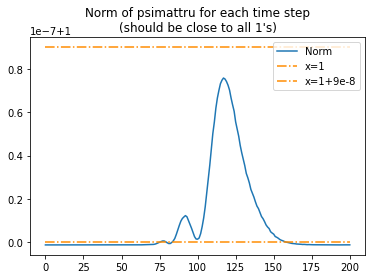

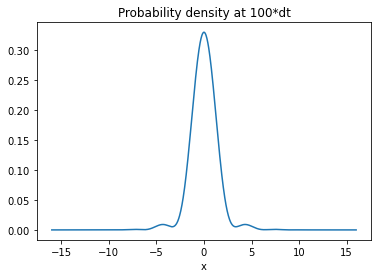

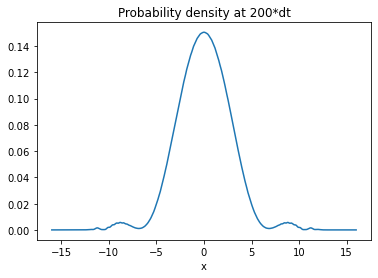

In [66]:
# set number of elements for toeplitz representation
# in the Fourier basis
ntoerep = 2 * nfb + 1

# this makes the training data by propagating the
# Fourier basis system directly (no Gaussian coefficients)
def mktraindata():
    # make the potential matrix in the Fourier basis
    vrow = vfbvec[:ntoerep] * (-1) ** np.arange(ntoerep)
    vmat = toeplitz(vrow, vrow.conj())

    # Hamiltonian matrix
    hmat = kmat + vmat
    # check hmat is Hermitian
    print('Check if hmat is Hermitian (should be close to zero):\n',
          nl.norm(hmat - hmat.T.conj()))

    # eigendecomposition
    spc, stts = np.linalg.eigh(hmat)

    # check if spec and states diagonalizes hmat
    # if this is close to zero it means that
    # hmat = states @ np.diag(spec) @ np.conj(states).T
    print('Check if spc and stts diagonalizes hmat (should be close to zero):\n',
          nl.norm(hmat @ stts - stts @ np.diag(spc)))

    # check if we have a unitary matrix
    print('Check if stts forms a unitary matrix (should be close to zero):\n',
          nl.norm(stts @ stts.conj().T - np.eye(ntoerep)))

    # make matrix for propagating a vector
    propamat = stts @ np.diag(np.exp(-1j*spc*dt)) @ np.conj(stts.T)

    # propagate a
    amat = np.zeros((nts + 1, ntoerep), dtype=np.complex128)
    amat[0,:] = np.copy(initavec)
    for j in range(nts):
        amat[j+1,:] = propamat @ amat[j,:]

    return amat

amattru = mktraindata()

# convert amattru into real space wave function
psimattru = amattru @ fbmat
# rough calculation of norm of psimattru for each time step
# print('Norm of psimattru for each time step (should be close to all 1\'s):\n',
#       np.sqrt(np.sum(np.abs(psimattru)**2, axis=1) * dx))
plt.plot(np.sum(np.abs(psimattru)**2, axis=1) * dx, label='Norm')
plt.hlines(1, 0, nts, linestyles='-.', colors='darkorange', label='x=1')
plt.hlines(1 + 9e-8, 0, nts, linestyles='-.', colors='darkorange', label='x=1+9e-8')
plt.title('Norm of psimattru for each time step\n(should be close to all 1\'s)')
plt.legend()
plt.show()

plt.plot(xvec, np.abs(amattru[100] @ fbmat)**2)
plt.title('Probability density at 100*dt')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(amattru[200] @ fbmat)**2)
plt.title('Probability density at 200*dt')
plt.xlabel('x')
plt.show()

<h3>Inverse Problem</h3>

---
**Code for Gaussian Basis Model of the Potential**

In [59]:
#Gaussian basis functions

# function for computing the real space grid points, xg,
# for the Gaussian basis functions give some J and L
def xgvecfn(J, L):
    # make vector of x points for Gaussian centers
    # with spacing h
    h = L/J
    xg = np.arange(-J, J+1) * h
    return xg


# function for generating Gaussian basis matrix (gmat)
def gbmatfn(x, xg, alpha):
    # make arrays that can be used in vectorized evaluations
    # row values are x1 and column values are x2
    xv, xgv = np.meshgrid(x, xg, sparse=True, indexing='ij')

    # vectorized version of Gaussian basis function
    # Gaussian centered at grid point j*h with shape parameter alpha
    # z_{ij} = x_i - j*h
    def gbm(z, alpha):
        return np.exp(-alpha * z**2)

    # make Gaussian basis matrix
    # We want [gbmat @ cfs](x_i) = vtrue(x_i), so each row
    # in gbmat is an x_i point and each column is a j*h
    # point. Given N x_i points and J j values, gbmat
    # is an NxJ matrix
    return gbm(xv - xgv, alpha)


# function for computing the Gaussian basis coefficients
# given a vector of the function evaluated on the real
# space grid of the Gaussian basis
def cmpgbcfs(fxg, xg, alpha):
    # make Gaussian basis matrix
    gbmat = gbmatfn(xg, xg, alpha)

    # solve gbmat @ gbcfs = fxjtrue
    # to compute Gaussian basis coefficients
    # gbmat must be a square matrix
    cfs = sl.solve(gbmat, fxg, assume_a='sym')

    return cfs

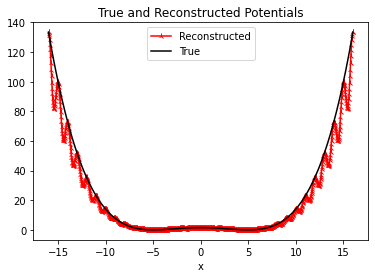

In [60]:
# setup of Gaussian basis

# set number of Gaussian basis functions
# the number of basis functions equals 2*16 + 1
bigJ = 16

# alpha determines the amount of overlap of our basis
# it shouldn't be too much or too little, it should also
# scale with the number of basis used.
# values of alpha to try: 4.0, 5.0, 6.0, 7.0
myalpha = 4.0

# this code computes the Gaussian basis coefficients
# for the true potential

xgvec = xgvecfn(bigJ, bigL)

cfstru = cmpgbcfs(v(xgvec), xgvec, myalpha)

# this forms the matrix used for converting Gaussian basis
# coefficients to real space (for plotting)
# xvec is the rows of the matrix, xgvec is the column
gmatplot = gbmatfn(xvec, xgvec, myalpha)

# reconstruct the potential from the Gaussian basis coefficients
vxtrurec = gmatplot @ cfstru

# plot real potential vs. reconstructed potential
plt.plot(xvec, vxtrurec, '2-r', label='Reconstructed')
plt.plot(xvec, vxtru, 'k', label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

In [61]:
# constant needed for making the potential matrix and its
# gradient in Gaussian representation
# this constant only depends on the number of Fourier
# basis functions and L
# kspace_n = 2 \pi n / (b - a) --> (b - a) = L + L
# thus kspace_n = \pi n / L
# n = {-2ng, ..., 2ng}, but we only need to look at
# n = {0, ..., 2ng} because the neg values are the
# conjugate of the positive values
ksvec = np.pi * np.arange(0, ntoerep) / bigL

In [62]:
# this code computes the potential matrix in the
# Fourier basis given a set of Gaussian basis coefficients.
# this computes the potential matrix directly by FT the Gaussian
# basis model. It should be a linear combo of FT Gaussians.

def mkgvmatgrdvmat(xg, L, alpha):
    # set number of Gaussian basis given some J
    ng = len(xg)

    # constants needed for making the potential matrix and its
    # gradient.
    cnstexpvec = np.exp(-ksvec ** 2 / (4 * alpha))
    cnsttrmmkgvmat = (1 / (2 * L)) * np.sqrt(np.pi / alpha) * cnstexpvec

    ksmes, xgmes = np.meshgrid(ksvec, xg, sparse=True, indexing='ij')
    # this should be a matrix with dimensions (ng x numkspace)
    # xg points make the rows and ks points make the columns
    cnstgfbmat = np.exp(-1j * ksmes * xgmes)


    @njit
    # cfs is the vector of Gaussian basis coefficients
    def mkgvmatfn(cfs):
        cfsexpvec = cnstgfbmat @ cfs.astype(np.complex128)
        column = cnsttrmmkgvmat * cfsexpvec
        row = column.conj()
        return toeplitz(r=row, c=column)


    # this code computes the gradient of the potential matrix
    # in the Fourier basis given a set of Gaussian basis
    # coefficients
    # this is the gradient of the potential matrix WRT
    # the Gaussian coefficients, so it should be a
    # tensor of dimensions (ng x nx x nfb) (i.e. the
    # potential matrix WRT each of the Gaussian basis functions
    gradgvmatrtn = np.zeros((ng, ntoerep, ntoerep), dtype=np.complex128)
    for i in range(ng):
        thiscfs = np.zeros(ng)
        thiscfs[i] = 1
        gradgvmatrtn[i] = mkgvmatfn(thiscfs)

    return mkgvmatfn, gradgvmatrtn

In [63]:
mkgvmat, gradgvmat = mkgvmatgrdvmat(xgvec, bigL, myalpha)
print(mkgvmat(cfstru).shape)
print(gradgvmat.shape)

(257, 257)
(33, 257, 257)


In [ ]:
# function for propagating system given a set
# of Gaussian coefficients
# nt sets the number of time steps to propagate
# the system in time
@njit
def propa(gbcfs, inita, nt, gvmatfn):
    # form the potential matrix (in the Fourier basis)
    # using a set of Gaussian basis coefficients
    vmat = gvmatfn(gbcfs)

    # construct Hamiltonian matrix (in Fourier basis)
    hmat = kmat + vmat

    # eigen-decomposition Hamiltonian matrix
    spc, stts = np.linalg.eigh(hmat)

    # form a vector propagator matrix
    propamat = stts @ np.diag( np.exp(-1j * spc * dt) ) @ stts.T.conj()

    # propagate the a vector, i.e., solve the *forward* problem
    amat = np.zeros((nt + 1, 2 * nfb + 1), dtype=np.complex128)
    amat[0, :] = np.copy(inita)
    for j in range(nt):
        amat[j + 1, :] = propamat @ amat[j, :]

    return spc, stts, amat

In [65]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

# define function for propagating lambda
@njit
def propl(spc, stts, amat, amattrain, nt):
    # form lambda vector propagator matrix
    proplmat = stts @ np.diag(np.exp(1j * spc * dt)) @ stts.T.conj()

    # propagate lambda vector
    lmat = np.zeros((nt + 1, 2 * nfb + 1), dtype=np.complex128)
    lmat[nt, :] = amat[nt, :] - amattrain[nt, :]
    for j in range(nt - 1, 0, -1):
        lmat[j, :] = amat[j, :] - amattrain[j, :] + proplmat @ lmat[j + 1, :]

    return lmat

---
**Adjoint Method Code**

In [67]:
from IPython.display import clear_output

def mkobjgrdfn(ng, nt, inita, amattrain, gvmatfn):
    # this code computes the objective function give
    # a set of Gaussian basis coefficients as input
    def objfn(cfs):
        global glbitrcntobj, glbobjhis, glbitrcntgrad, glbgradhis

        # propagate initial state with cfs
        spc, stts, amat = propa(cfs, inita, nt, gvmatfn)

        # compute objective
        residue = amat - amattrain
        objct = 0.5*np.real(np.sum(np.conj(residue)*residue))

        # advance objective count +1
        glbitrcntobj += 1
        # roll the history back one and replace with newest value
        # i.e. put the newest value on the end of the stack
        glbobjhis = np.roll(glbobjhis, -1)
        glbobjhis[-1] = objct
        # print the latest values of the Lagrangian
        # print(f'{glbitrcnt} Objective={glbobjhis[-1]}', end='\x1b[2J\n')  # \r')
        clear_output()
        print(f'{glbitrcntobj} Objective={glbobjhis[-1]}',
              f'{glbitrcntgrad} Grad Norm={glbgradhis[-1]}', sep='\n')

        return objct

    # compute the gradients
    # the input x is the vector of modeling parameters (theta or thetahat)
    @njit
    def grdhlpfn(spc, stts):
        dmat = np.zeros((ng, ntoerep, ntoerep), dtype=np.complex128)
        expspc = np.exp(-1j * dt * spc)
        mask = np.zeros((ntoerep, ntoerep), dtype=np.complex128)
        for ii in range(ntoerep):
            for jj in range(ntoerep):
                if np.abs(spc[ii] - spc[jj]) < 1e-8:
                    mask[ii,ii] = expspc[ii]
                else:
                    mask[ii,jj] = (expspc[ii] - expspc[jj])/(-1j * dt * (spc[ii] - spc[jj]))

        for iii in range(ng):
            thisA = stts.conj().T @ gradgvmat[iii] @ stts
            qmat = thisA * mask
            dmat[iii,:,:] = -1j * dt * stts @ qmat @ stts.conj().T

        return dmat

    def grdfn(cfs):
        global glbitrcntobj, glbobjhis, glbitrcntgrad, glbgradhis

        # propagate initial state with cfs
        spc, stts, amat = propa(cfs, inita, nt, gvmatfn)

        # propagate lambda with glbamat
        lmat = propl(spc, stts, amat, amattrain, nt)

        # compute alldmat
        dmat = grdhlpfn(spc, stts)
        # compute all entries of the gradient at once
        gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(lmat[1:, :]), dmat, amat[:-1, :]))

        # advance grad count +1
        glbitrcntgrad += 1
        # roll the history back one and replace with newest value
        # i.e. put the newest value on the end of the stack
        glbgradhis = np.roll(glbgradhis, -1)
        glbgradhis[-1] = nl.norm(gradients)
        # print the latest values of the Lagrangian
        # print(f'{glbitrcnt} Objective={glbobjhis[-1]}', end='\x1b[2J\n')  # \r')
        clear_output()
        print(f'{glbitrcntobj} Objective={glbobjhis[-1]}',
              f'{glbitrcntgrad} Grad Norm={glbgradhis[-1]}', sep='\n')

        return gradients

    return objfn, grdfn

In [68]:
def resethis(objhislen, gradhislen):
    global glbitrcntobj, glbobjhis, glbitrcntgrad, glbgradhis
    # create the objective's history
    glbobjhis = np.zeros(objhislen)
    # initialize variable for counting number of iterations
    glbitrcntobj = 0
    # create the objective's history
    glbgradhis = np.zeros(gradhislen)
    # initialize variable for counting number of iterations
    glbitrcntgrad = 0

In [69]:
# check if the Lagrangian of the true theta, xtrue, gives 0

# create objfn and grdfn functions
objectfn, gradfn = mkobjgrdfn(len(xgvec), nts, initavec, amattru, mkgvmat)

# reset objective and grad norm histories
resethis(1, 1)

objectfn(cfstru)

1 Objective=6.473213555560848
0 Grad Norm=0.0


6.473213555560848

In [70]:
# reset objective and grad norm histories
resethis(1, 1)

# check that the gradient of the Lagrangian is zero for the true theta
gradfn(cfstru)

0 Objective=0.0
1 Grad Norm=27.158899910659592


array([ 1.67649683e-07, -1.78463779e-05, -1.22998155e-04, -2.29457614e-04,
       -1.59539391e-03, -7.69387530e-03, -1.10182438e-02, -1.78436999e-02,
       -2.69380641e-02, -3.48256146e-02, -4.35384359e-02, -6.86468021e-02,
       -1.80741261e-01, -6.41648325e-01, -2.40294409e+00, -1.04193661e+01,
       -2.25339357e+01, -1.04301131e+01, -2.40713010e+00, -6.43012942e-01,
       -1.81087915e-01, -6.86662917e-02, -4.34664901e-02, -3.47291688e-02,
       -2.68520606e-02, -1.78002273e-02, -1.10196291e-02, -7.72952442e-03,
       -1.63021848e-03, -2.28607636e-04, -1.21838690e-04, -1.85794024e-05,
        1.67649683e-07])

---
**Initialize with true coefficients perturbed by random normally distributed noise**

In [41]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cfstru.copy()
# cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfstru.shape)
cfftrub += 10.0 * np.random.default_rng(seed).normal(size=cfstru.shape)

In [42]:
print(cfftrub.shape)

(33,)


In [46]:
hislen = 50
# reset objective and grad norm histories
resethis(hislen, hislen)

restrub = so.minimize(objectfn, cfftrub, jac=gradfn,
                      options={'maxiter': 300, 'disp': True}).x

279 Objective=86.62955293443557
279 Grad Norm=1.4431916632903411e-05
Optimization terminated successfully.
         Current function value: 86.629553
         Iterations: 262
         Function evaluations: 279
         Gradient evaluations: 279


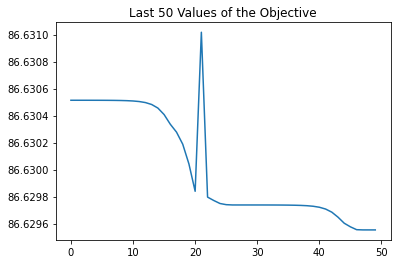

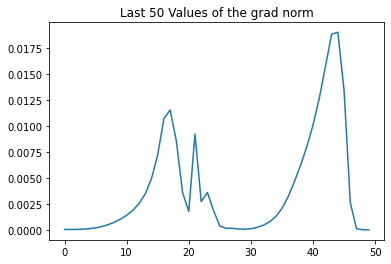

In [47]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {hislen} Values of the Objective')
plt.show()

# plot the grad norm history
plt.plot(glbgradhis)
plt.title(f'Last {hislen} Values of the grad norm')
plt.show()

280 Objective=86.62955293443557
279 Grad Norm=1.4431916632903411e-05
Lagrangian for predicted theta:  86.62955293443557
RND predicted theta vs. true theta:  0.3406128368333897
RND predicted v vs. true v:  439.90897743668063
RND predicted v vs. training v:  0.32413470779101655


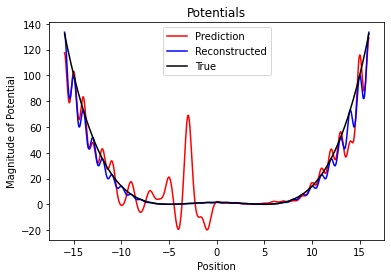

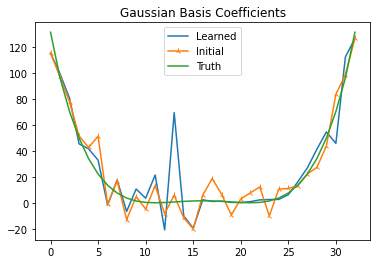

In [48]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(restrub))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(restrub - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vtrubprdc = gmatplot @ restrub

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vxtru - vtrubprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vtrubprdc) / nl.norm(vxtrurec))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vtrubprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Reconstructed')
plt.plot(xvec[trim:-trim], vxtru[trim:-trim], color='black', label='True')
plt.title('Potentials')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

plt.plot(restrub, label='Learned')
plt.plot(cfftrub, '2-', label='Initial')
plt.plot(cfstru, label='Truth')
plt.title('Gaussian Basis Coefficients')
plt.legend()
plt.show()

---
**Initialize theta with uniform random values**

In [72]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-100, high=100, size=cfstru.shape)
# cffform = np.random.default_rng(seed).uniform(low=-0.5, high=0.5, size=cfstru.shape) - 0.5

In [73]:
hislen = 50
# reset objective and grad norm histories
resethis(hislen, hislen)

resform = so.minimize(objectfn, cffform, jac=gradfn, method='BFGS',
                      options={'disp': True, 'maxiter': 100}).x

179 Objective=57.575410569461
179 Grad Norm=8.553934801959299
         Current function value: 57.575411
         Iterations: 100
         Function evaluations: 179
         Gradient evaluations: 179


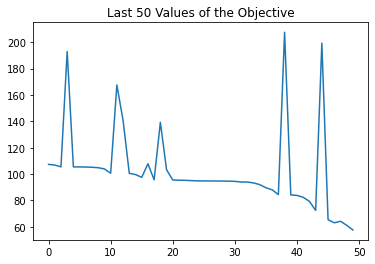

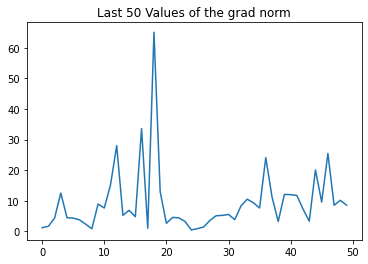

In [74]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {hislen} Values of the Objective')
plt.show()

# plot the grad norm history
plt.plot(glbgradhis)
plt.title(f'Last {hislen} Values of the grad norm')
plt.show()

180 Objective=57.575410569461
179 Grad Norm=8.553934801959299
Lagrangian for predicted theta:  57.575410569461
RND predicted theta vs. true theta:  1.837527637641286
RND predicted v vs. true v:  2269.384370151503
RND predicted v vs. training v:  1.8456199232959725
[ 36.51342381 120.43169183  14.06072579  97.67577512  70.38293027
  98.6407622   65.27817396  43.92970986  90.06953279  47.58601522
  11.05231549  23.17032101  58.45641603  59.7467165  171.99705975
   3.29636655   1.56664531   4.25261218 206.46379956 175.57714875
  91.73862318  31.15551905  31.70072427  18.23458424  93.91125978
  86.6080425   25.90088407  15.76599103 133.53901561  99.81868251
   1.03785567 111.39099795  84.68957834]


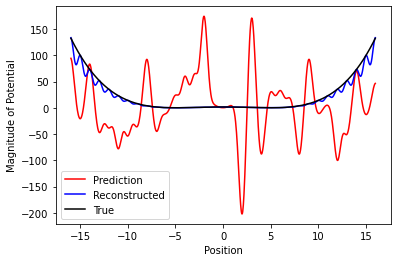

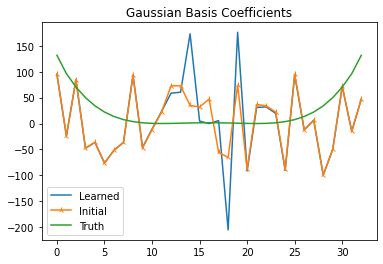

In [75]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(resform))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resform - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vformprdc = gmatplot @ resform

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vxtru - vformprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vformprdc) / nl.norm(vxtrurec))

print(np.abs(resform - cfstru))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Reconstructed')
plt.plot(xvec[trim:-trim], vxtru[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

plt.plot(resform, label='Learned')
plt.plot(cffform, '2-', label='Initial')
plt.plot(cfstru, label='Truth')
plt.title('Gaussian Basis Coefficients')
plt.legend()
plt.show()

---

In [35]:
newJ = 32

xgvecnewJ = xgvecfn(bigJ, bigL)

gmatplotnewJ = gbmatfn(xvec, xgvecnewJ, myalpha)

gvmatfnnewJ, gradgvmatnewJ = mkgvmatgrdvmat(xgvecnewJ, bigL, myalpha)

objfnnewJ, grdfnnewJ = mkobjgrdfn(len(xgvecnewJ), amattru, gvmatfnnewJ)

# generating Gaussian basis matrix for converting oldJ to
# newJ's finner newxg real space grid
gbmatoldtonew = gbmatfn(xgvecnewJ, xgvec, myalpha)

# construct the potential on newJ's real space grid
vxnew = gbmatoldtonew @ resform

# compute Gaussian basis coefficients for newJ
cfsnew = cmpgbcfs(vxnew, xgvecnewJ, myalpha)

In [36]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjhis = np.zeros(objechistlen)
# initialize variable for counting the number of iterations
glbitrcnt = 0

resformnew = so.minimize(objfnnewJ, cfsnew, jac=grdfnnewJ, method='BFGS',
                         options={'disp': True, 'maxiter': 100}).x

 Lagrangan=0.1774317923425041420 Lagrangan=0.177422603587244122 Lagrangan=0.1774201472766964724 Lagrangan=0.1774131405141601326 Lagrangan=0.177395747935332828 Lagrangan=0.1773897175720953230 Lagrangan=0.1773886879869044632 Lagrangan=0.177386222999698534 Lagrangan=0.1773791405495060436 Lagrangan=0.177373464210647438 Lagrangan=0.1773723862473849740 Lagrangan=0.1773713598278472442 Lagrangan=0.177368079041914544 Lagrangan=0.1773586757253734546 Lagrangan=0.1773473933360567648 Lagrangan=0.177340024524957450 Lagrangan=0.1773347059760497852 Lagrangan=0.1773305352834999654 Lagrangan=0.177328565662653656 Lagrangan=0.177327475803934658 Lagrangan=0.1773270683056499360 Lagrangan=0.17732586541900562 Lagrangan=0.1773217516467380264 Lagrangan=0.1773084177643655766 Lagrangan=0.177274086962262868 Lagrangan=0.1772311584427970870 Lagrangan=0.1772186434755570772 Lagrangan=0.177217541162029374 Lagrangan=0.177214081721053876 Lagrangan=0.1772024726756576478 Lagrangan=0.177168964972493380 Lagrangan=0.177132206

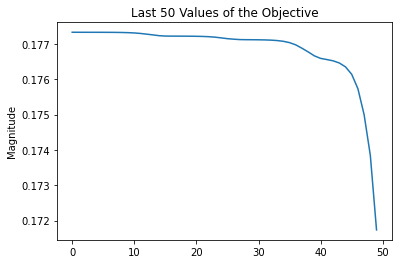

In [37]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {objechistlen} Values of the Objective')
plt.ylabel('Magnitude')
plt.show()

Lagrangian for predicted theta:  0.17173767331772852
RND predicted theta vs. true theta:  1.052018146544605
RND predicted v vs. true v:  1387.6745209824633
RND predicted v vs. training v:  1.0535628736264389


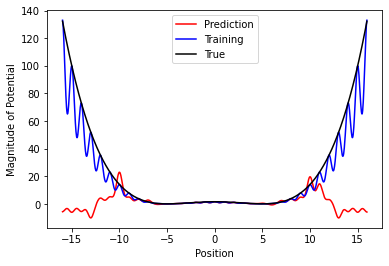

In [38]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(resformnew))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resformnew - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vformprdcnew = gmatplotnewJ @ resformnew

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vxtru - vformprdcnew))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vformprdcnew) / nl.norm(vxtrurec))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdcnew[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Training')
plt.plot(xvec[trim:-trim], vxtru[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

**Propagate System with Found Coefficents**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


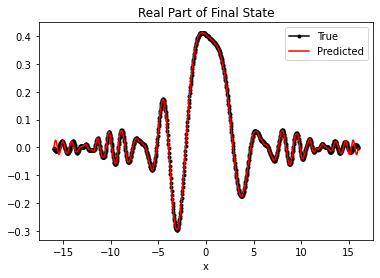

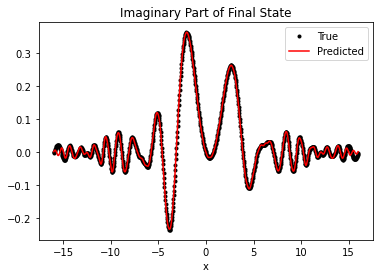

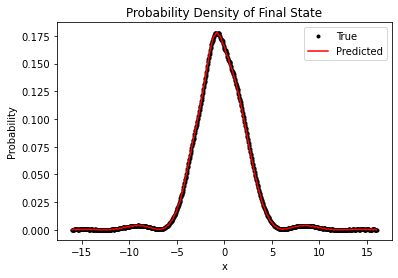

In [30]:
# propagate inita using the predicted coefficients
_, _, amatform, _ = propa(resform.x, initavec)
    
# transform amat to real space
psimatform = amatform @ fbmat

print('Element difference:\n', psimatform[-1] - psimattru[-1])
print('Norm of difference:', nl.norm(psimatform - psimattru))

plt.plot(xvec, psimattru[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattru[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattru[-1]) ** 2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()